In [1]:
# -------------------------------------------------------------------------------------------------
# LOAD REQUIRED LIBRARIES
# -------------------------------------------------------------------------------------------------
%matplotlib inline
import netCDF4
from distutils.util import strtobool
import pylab
import matplotlib
import matplotlib.pyplot as plt
import pcraster as pcr
import sys
import os
import platform
import numpy as np
import pyproj as pyproj
import datetime
import pdb
import time
import bmi.wrapper
# import pcrglobwb_203_30min_2way as pcrglobwb_bmi_v203
# from pcrglobwb_203_30min_2way import pcrglobwb_bmi
# from pcrglobwb_203_30min_2way import disclaimer
import model as pcrglobwb_bmi_v203
from model import pcrglobwb_bmi
from model import disclaimer
from coupling_PCR_FM_2way import coupling_functions
from coupling_PCR_FM_2way import model_functions
from coupling_PCR_FM_2way import utils
from coupling_PCR_FM_2way import configuration
%config Application.log_level="INFO"

/nfs/admin/hpc/sw/python-2.7.8/lib/python2.7/site-packages/matplotlib-1.4.0-py2.7-linux-x86_64.egg/matplotlib/__init__.py:1256: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# -------------------------------------------------------------------------------------------------
# IMPORT MODEL SETTINGS FROM INI-FILE/SET-FILE
# -------------------------------------------------------------------------------------------------

# arg = r'/home/jannis/PhD/scripts/2WAY/2way_AMA_1d2d_codeDevelopment.ini'
arg = r'/nfs/home4/hoch/data/scripts/PCR05min_2_LFP1km_NIG.ini'

config = configuration.Configuration()
#config.parse_configuration_file(sys.argv[1])
config.parse_configuration_file(arg)

In [3]:
# -------------------------------------------------------------------------------------------------
# SPECIFY MODEL SETTINGS
# -------------------------------------------------------------------------------------------------

model_type = config.model_type['model_type']

use_2way = strtobool(config.general_settings['2way coupling'])

latlon = strtobool(config.general_settings['latlon'])
if latlon == False:
    inProj  = pyproj.Proj(init=config.model_settings['model_projection'])

use_Fluxes = strtobool(config.general_settings['use_Fluxes'])

use_RFS = strtobool(config.general_settings['use_RFS'])
if use_2way == True:
    use_RFS = True

verbose = strtobool(config.general_settings['verbose'])

couple_channelStorage = False

In [4]:
# -------------------------------------------------------------------------------------------------
# SPECIFY NUMERICAL SETTINGS
# -------------------------------------------------------------------------------------------------

nr_model_timesteps                    = int(config.numerical_settings['number_of_timesteps'])
update_step                           = int(config.numerical_settings['update_step'])

secPerDay                             = 86400.
end_time 							  = nr_model_timesteps * secPerDay
fraction_timestep 					  = secPerDay / update_step

threshold_inundated_depth             = float(config.numerical_settings['threshold_inundated_depth'])

# other
missing_value_landmask                = 255
missing_value_pcr                     = -999

In [5]:
# -------------------------------------------------------------------------------------------------
# SET PATHS TO MODELS
# -------------------------------------------------------------------------------------------------

# hydrodynamics
model_dir       	= config.model_settings['model_dir']
model_file      	= config.model_settings['model_file']
model_proj			= config.model_settings['model_projection']

# hydrology
config_pcr       	=  config.PCR_settings['config_pcr']
configPCR           = configuration.Configuration()
configPCR.parse_configuration_file(config_pcr)
inputDIR 			= configPCR.globalOptions['inputDir']
clone_pcr 			= os.path.join(inputDIR, configPCR.globalOptions['cloneMap'])
landmask_pcr 		= os.path.join(inputDIR, configPCR.globalOptions['landmask'])
LDD                 = os.path.join(inputDIR, configPCR.routingOptions['lddMap'])

In [6]:
# -------------------------------------------------------------------------------------------------
# SET PATHS TO .SO / .DLL FILES
# -------------------------------------------------------------------------------------------------

# these may be changed according to personal file and folder structure
if model_type == 'DFM':
#     model_path = '/home/jannis/Programmes/DFLOWFM/lib/libdflowfm.so'
    model_path = '/home/jannis/Programmes/DFLOWFM/lib/libdflowfm.so'
elif model_type == 'LFP':
#     model_path = '/home/jannis/Programmes/LISFLOODFP/lisflood-bmi-v5.9/liblisflood.so'
    model_path = '/nfs/home4/hoch/GLOFRIM2/glofrim/lisflood-bmi-v5.9/liblisflood.so'
else:
    sys.exit('\nno adequate model defined in configuration file - define either DFM or LFP!\n')

In [7]:
# -------------------------------------------------------------------------------------------------
# INITIALIZE PCR-GLOBWB
# -------------------------------------------------------------------------------------------------

# initiate logging and define folder for verbose-output
verbose_folder = model_functions.write2log(model_dir, model_file, latlon, use_2way, use_Fluxes, use_RFS, use_floodplain_infiltration_factor=False, adjust_initial_groundwater=False, verbose=False, moment='start')
print 'Model Start-Time: ', datetime.datetime.now()
print ''

# initiate PCR-GLOBWB
hydrologicModel = pcrglobwb_bmi_v203.pcrglobwb_bmi.pcrglobwbBMI()
hydrologicModel.initialize(config_pcr)
print '\n>>> PCR Initialized <<<\n'

2018-03-21 13:24:44,761 model.disclaimer INFO 

 PCR-GLOBWB (PCRaster Global Water Balance) Global Hydrological Model                       

 Copyright (C) 2016, Ludovicus P. H. (Rens) van Beek, Edwin H. Sutanudjaja, Yoshihide Wada, 
 Joyce H. C. Bosmans, Niels Drost, Inge E. M. de Graaf, Kor de Jong, Patricia Lopez Lopez,  
 Stefanie Pessenteiner, Oliver Schmitz, Menno W. Straatsma, Niko Wanders, Dominik Wisser,   
 and Marc F. P. Bierkens,                                                                   
 Faculty of Geosciences, Utrecht University, Utrecht, The Netherlands                       

 This program comes with ABSOLUTELY NO WARRANTY                                             
 This is free software, and you are welcome to redistribute it under certain conditions     
 See the LICENSE file for more details                                                      


2018-03-21 13:24:44,762 model.configuration INFO Model run started at 2018-03-21 13:24:44.626224
2018-03-21 13:


##############################
### MODEL COUPLING STARTED ###
##############################

model file chosen:  LFP_NIG_Jeison_Yamazaki.par
2way coupling activated:  True
lat-lon on:  True
fluxes on:  True
RFS on:  True
use floodplain infiltration factor:  False
adjust initial groundwater:  False
verbose mode on:  False

Model Start-Time:  2018-03-21 13:24:44.625927



2018-03-21 13:24:46,686 model.meteo INFO Temperature forcing will be downscaled to the cloneMap resolution.
2018-03-21 13:24:51,746 model.landSurface INFO Irrigation is included/considered in this run.
2018-03-21 13:24:51,748 model.landSurface INFO Domestic water demand is included in the calculation.
2018-03-21 13:24:51,750 model.landSurface INFO Industry water demand is included in the calculation.
2018-03-21 13:24:51,751 model.landSurface INFO Livestock water demand is included in the calculation.
2018-03-21 13:24:51,753 model.landSurface INFO Using the dynamicIrrigationArea option. Extent of irrigation areas is based on the file provided in the 'historicalIrrigationArea'.
2018-03-21 13:24:52,957 model.landSurface INFO Monthly desalination water is included.
2018-03-21 13:24:55,333 model.landSurface INFO Using/incorporating the predefined surface water source of Siebert et al. (2010) for satisfying irrigation and livestock demand.
2018-03-21 13:24:57,701 model.landSurface INFO Using

2018-03-21 13:26:25,769 model.reporting INFO Creating the netcdf file for monthly average reporting for variable satDegLow.
2018-03-21 13:26:25,776 model.reporting INFO Creating the netcdf file for monthly average reporting for variable surfaceWaterStorage.
2018-03-21 13:26:25,783 model.reporting INFO Creating the netcdf file for monthly average reporting for variable snowFreeWater.
2018-03-21 13:26:25,791 model.reporting INFO Creating the netcdf file for monthly average reporting for variable discharge.
2018-03-21 13:26:25,798 model.reporting INFO Creating the netcdf file for monthly average reporting for variable totalWaterStorageThickness.
2018-03-21 13:26:25,805 model.reporting INFO Creating the netcdf file for monthly average reporting for variable storUppTotal.
2018-03-21 13:26:25,812 model.reporting INFO Creating the netcdf file for monthly average reporting for variable storLowTotal.
2018-03-21 13:26:25,819 model.reporting INFO Creating the netcdf file for monthly average repor


>>> PCR Initialized <<<



In [ ]:
# -------------------------------------------------------------------------------------------------
# SPIN-UP PCR-GLOBWB
# -------------------------------------------------------------------------------------------------

# spin-up PCR-GLOBWB
hydrologicModel.spinup()

2018-03-21 13:36:29,513 model.pcrglobwb_bmi INFO Spin-Up #Total Years: 2
2018-03-21 13:36:29,515 model.pcrglobwb_bmi INFO Spin-Up Run No. 1
2018-03-21 13:37:02,387 model.meteo INFO Temperature forcing will be downscaled to the cloneMap resolution.
2018-03-21 13:38:23,807 model.landSurface INFO Irrigation is included/considered in this run.
2018-03-21 13:38:23,809 model.landSurface INFO Domestic water demand is included in the calculation.
2018-03-21 13:38:23,811 model.landSurface INFO Industry water demand is included in the calculation.
2018-03-21 13:38:23,812 model.landSurface INFO Livestock water demand is included in the calculation.
2018-03-21 13:38:23,814 model.landSurface INFO Using the dynamicIrrigationArea option. Extent of irrigation areas is based on the file provided in the 'historicalIrrigationArea'.
2018-03-21 13:38:44,705 model.landSurface INFO Monthly desalination water is included.
2018-03-21 13:39:31,181 model.landSurface INFO Using/incorporating the predefined surfac

2018-03-21 14:05:42,025 model.reporting INFO Creating the netcdf file for monthly average reporting for variable topWaterLayer.
2018-03-21 14:05:42,034 model.reporting INFO Creating the netcdf file for monthly average reporting for variable satDegLow.
2018-03-21 14:05:42,054 model.reporting INFO Creating the netcdf file for monthly average reporting for variable surfaceWaterStorage.
2018-03-21 14:05:42,067 model.reporting INFO Creating the netcdf file for monthly average reporting for variable snowFreeWater.
2018-03-21 14:05:42,085 model.reporting INFO Creating the netcdf file for monthly average reporting for variable discharge.
2018-03-21 14:05:42,096 model.reporting INFO Creating the netcdf file for monthly average reporting for variable totalWaterStorageThickness.
2018-03-21 14:05:42,106 model.reporting INFO Creating the netcdf file for monthly average reporting for variable storUppTotal.
2018-03-21 14:05:42,122 model.reporting INFO Creating the netcdf file for monthly average repo

2018-03-21 14:07:03,223 model.virtualOS WARNING 
WARNING related to the netcdf file: /projects/0/dfguu/data/hydroworld/pcrglobwb2_input_release/latest_release/pcrglobwb2_input/global_05min/landSurface/landCover/naturalTall/interceptCapInputForest.nc ; variable: interceptCapInput !!!!!!
The date 1993-01-01 is NOT available. The date 2000-1-1 is used.

2018-03-21 14:07:06,956 model.virtualOS WARNING 
WARNING related to the netcdf file: /projects/0/dfguu/data/hydroworld/pcrglobwb2_input_release/latest_release/pcrglobwb2_input/global_05min/landSurface/landCover/naturalTall/coverFractionInputForest.nc ; variable: coverFractionInput !!!!!!
The date 1993-01-01 is NOT available. The date 2000-1-1 is used.

2018-03-21 14:07:10,882 model.landSurface INFO Updating land cover: grassland
2018-03-21 14:07:10,924 model.virtualOS WARNING 
WARNING related to the netcdf file: /projects/0/dfguu/data/hydroworld/pcrglobwb2_input_release/latest_release/pcrglobwb2_input/global_05min/landSurface/landCover/nat

In [8]:
# -------------------------------------------------------------------------------------------------
# INITIALIZING HYDRODYNAMIC MODEL
# -------------------------------------------------------------------------------------------------

# initiate hydraulic model
hydrodynamicModel = bmi.wrapper.BMIWrapper(engine = model_path, configfile = (os.path.join(model_dir, model_file)))
hydrodynamicModel.initialize()
print '\n>>> ',model_type,' Initialized <<<\n'

2018-03-21 13:30:53,276 bmi.wrapper INFO Loading library from path /nfs/home4/hoch/GLOFRIM2/glofrim/lisflood-bmi-v5.9/liblisflood.so
2018-03-21 13:30:53,410 bmi.wrapper INFO Loading model /nfs/home4/hoch/data/LFP/NIG/Jeison_1km_Yamazaki/LFP_NIG_Jeison_Yamazaki.par in directory /nfs/home4/hoch/data/LFP/NIG/Jeison_1km_Yamazaki



>>>  LFP  Initialized <<<



In [9]:
# -------------------------------------------------------------------------------------------------
# EXCTRACTING RELEVANT DATA FROM MODELS
# -------------------------------------------------------------------------------------------------

if model_type == 'DFM':

    #- retrieving data from Delft3D FM
    bottom_lvl_1D, bottom_lvl_2D, cellAreaSpherical_1D, cellAreaSpherical_2D, \
        hydrodynamic_coords_1D, hydrodynamic_coords_2D, separator_1D  = model_functions.extractModelData_DFM(hydrodynamicModel, 
                                                                                                             use_RFS, 
                                                                                                             use_2way)

    print '\n>>> DFM data retrieved <<<\n'
    
elif model_type == 'LFP':
    
    #- retrieving data from LISFLOOD-FP
    DEM, cellArea, SGCQin, SGCwidth, SGCz, list_x_coords, list_y_coords, list_x_coords_2way, \
        list_y_coords_2way, i_1d, j_1d, i_2d, j_2d, dx, dy  = model_functions.extractModelData_LFP(hydrodynamicModel,
                                                                                                  use_RFS,
                                                                                                  use_2way)
    
    hydrodynamic_coords_1D = coupling_functions.getVerticesFromMidPoints(list_x_coords, list_y_coords, dx, dy, verbose)
    hydrodynamic_coords_2D = coupling_functions.getVerticesFromMidPoints(list_x_coords_2way, list_y_coords_2way, dx, dy, verbose)
    
    coupledFPindices_1way = zip(i_1d, j_1d)
    coupledFPindices_2way = zip(i_2d, j_2d)
    
    separator_1D = 0.
    
    print '\n>>> LFP data retrieved <<<\n'

#- computing PCR-coordinates
cellarea_data_pcr, landmask_data_pcr, clone_data_pcr = model_functions.extractModelData_PCR(hydrologicModel, 
                                                                                            landmask_pcr, 
                                                                                            clone_pcr)
PCRcoords = coupling_functions.getPCRcoords(landmask_data_pcr)
print '\n>>> PCR data retrieved <<<\n'

/nfs/home4/hoch/GLOFRIM2/glofrim/coupling/coupling_PCR_FM_2way/model_functions.py:230: RuntimeWarning: invalid value encountered in greater
  i_1d, j_1d = np.where(np.logical_and(SGCwidth > 0., DEM != 1.00000000e+10, DEM != -9999))
/nfs/home4/hoch/GLOFRIM2/glofrim/coupling/coupling_PCR_FM_2way/model_functions.py:241: RuntimeWarning: invalid value encountered in less_equal
  i_2d, j_2d = np.where(np.logical_and(SGCwidth <= 0., DEM != 1.00000000e+10, DEM != -9999))



>>> LFP data retrieved <<<


>>> PCR data retrieved <<<



/nfs/admin/hpc/sw/python-2.7.8/lib/python2.7/site-packages/matplotlib-1.4.0-py2.7-linux-x86_64.egg/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


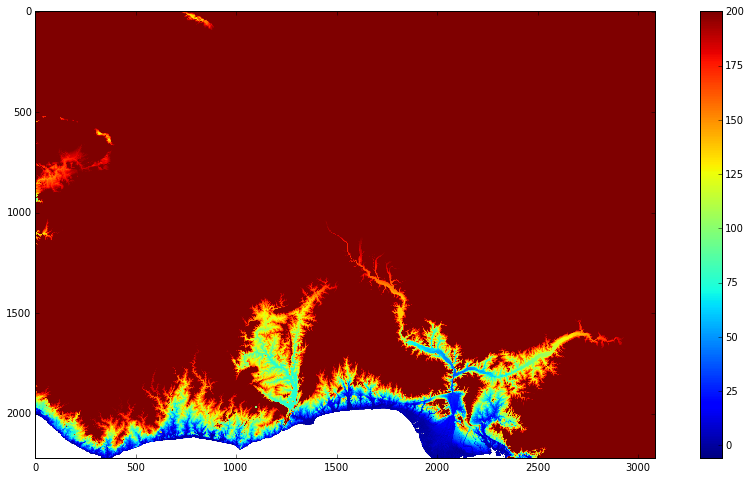

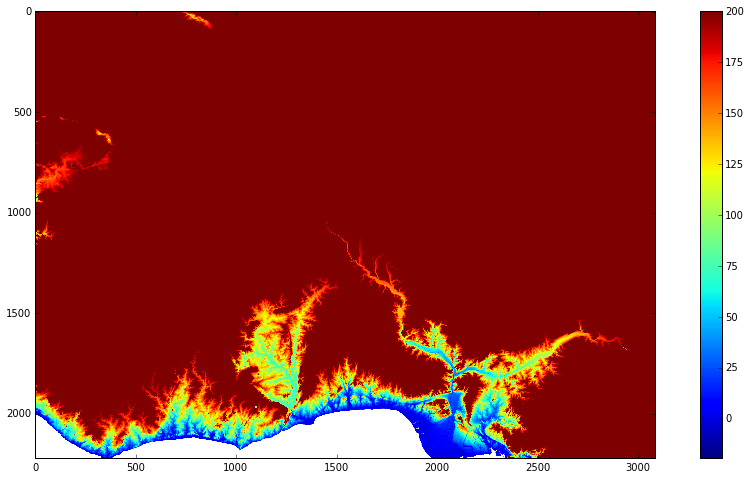

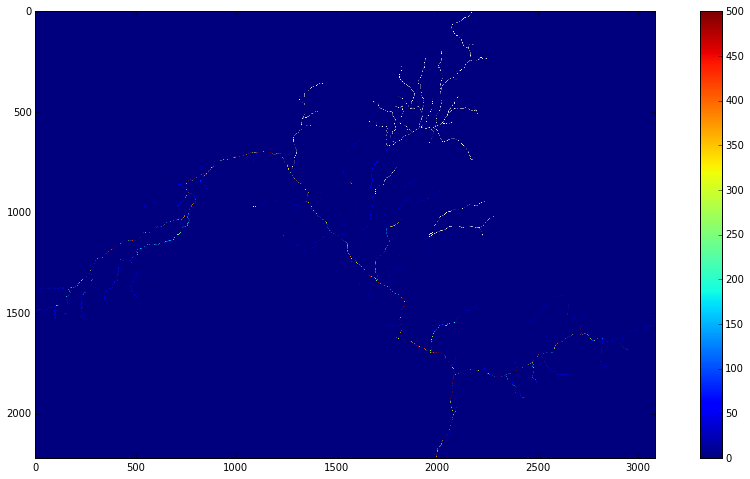

In [10]:
if model_type == 'LFP':
    plt.figure(figsize=(16,8))
    plt.imshow(DEM, vmax=200)
    plt.colorbar()
    plt.figure(figsize=(16,8))
    plt.imshow(SGCz, vmax=200)
    plt.colorbar()
    plt.figure(figsize=(16,8))
    plt.imshow(SGCwidth, vmax=500)
    plt.colorbar()

In [ ]:
# -------------------------------------------------------------------------------------------------
# ACTIVATING COUPLING FOR RELEVANT PCR SECTIONS
# -------------------------------------------------------------------------------------------------

hydrologicModel.set_var(('grassland','ActivateCoupling'), 'True') #2way
hydrologicModel.set_var(('forest','ActivateCoupling'), 'True') #2way
hydrologicModel.set_var(('routing','ActivateCoupling'), 'True')
hydrologicModel.set_var(('WaterBodies', 'ActivateCoupling'), 'True')

In [ ]:
# -------------------------------------------------------------------------------------------------
# COUPLING THE GRIDS
# -------------------------------------------------------------------------------------------------

# linking PCR-cells with 1D hydrodynamic cells (since use_RFS=True)
couple_HDYN_2_HLOG, couple_HLOG_2_HDYN, coupled_HLOG_indices = coupling_functions.assignPCR2cells(landmask_pcr, 
                                                                                                  hydrodynamic_coords_1D, 
                                                                                                  verbose)

print len(hydrodynamic_coords_1D)
print len(couple_HDYN_2_HLOG)

# linking PCR-cells with 2D hydrodynamic cells
couple_HDYN_2_HLOG_2way, couple_HLOG_2_HDYN_2way, coupled_HLOG_indices_2way = coupling_functions.assignPCR2cells(landmask_pcr, 
                                                                                                                 hydrodynamic_coords_2D, 
                                                                                                                 verbose)

print len(hydrodynamic_coords_2D)
print len(couple_HDYN_2_HLOG_2way)

In [ ]:
# -------------------------------------------------------------------------------------------------
# TURNING OFF ROUTING BY PCR IN COUPLED AREA
# -------------------------------------------------------------------------------------------------

newLDD = model_functions.noLDD(hydrologicModel, coupled_HLOG_indices, verbose_folder, verbose)

plt.figure()
plt.imshow(newLDD)
plt.colorbar()
#plt.savefig(os.path.join(verbose_folder,'coupledLDD.png'), dpi=300)

In [ ]:
if model_type == 'LFP':
    bottom_lvl_1d = SGCz[i_1d,j_1d]
    bottom_lvl_2d = SGCz[i_2d,j_2d]

bottomElevation_HDYN1D_2_HLOG_BMI = model_functions.determine_bottomElev1D_Hydrodynamics(couple_HLOG_2_HDYN,
                                                                                         coupled_HLOG_indices,
                                                                                         bottom_lvl_1d,
                                                                                         landmask_pcr)

plt.figure(figsize=(16,8))
plt.title('upscaled 1D bottom level elevation [m+NN] ' + str(model_type))
plt.imshow(bottomElevation_HDYN1D_2_HLOG_BMI, vmax=100)
plt.colorbar()

In [ ]:
if model_type == 'DFM':
    current_water_depth = hydrodynamicModel.get_var('s1') - hydrodynamicModel.get_var('bl')
    current_water_depth_1D = current_water_depth[separator_1D:]
    current_water_depth_2D = current_water_depth[:separator_1D]
elif model_type == 'LFP':
    current_water_depth = np.copy(hydrodynamicModel.get_var('H'))
    current_water_depth_1D = current_water_depth[i_1d,j_1d]
    current_water_depth_2D = current_water_depth[i_2d,j_2d]
    cellAreaSpherical_1D = cellArea[i_1d,j_1d]
    cellAreaSpherical_2D = cellArea[i_2d,j_2d]

In [ ]:
inundatedArea_HDYN1D_2_HLOG, \
    inundatedArea_HDYN1D_2_HLOG_BMI = model_functions.determine_InundationArea1D_Hydrodynamics(couple_HLOG_2_HDYN,
                                                                                               coupled_HLOG_indices,
                                                                                               current_water_depth_1D,
                                                                                               threshold_inundated_depth,
                                                                                               cellAreaSpherical_1D,
                                                                                               cellarea_data_pcr,
                                                                                               landmask_pcr)

In [ ]:
inundatedArea_HDYN2D_2_HLOG, \
    inundatedArea_HDYN2D_2_HLOG_BMI, \
        inundatedFraction_HDYN2D_2_HLOG, \
            inundatedFraction_HDYN2D_2_HLOG_BMI = model_functions.determine_InundationArea2D_Hydrodynamics(couple_HLOG_2_HDYN_2way,
                                                                                                           coupled_HLOG_indices_2way,
                                                                                                           current_water_depth_2D,
                                                                                                           threshold_inundated_depth,
                                                                                                           cellAreaSpherical_2D,
                                                                                                           cellarea_data_pcr,
                                                                                                           landmask_pcr)

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('inundatedArea (1D) [m2]')
plt.imshow(inundatedArea_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('inundatedArea (2D) [m2]')
plt.imshow(inundatedArea_HDYN2D_2_HLOG_BMI, vmax=np.max(inundatedArea_HDYN1D_2_HLOG_BMI))
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('inundatedFraction (2D) [m2/m2]')
plt.imshow(inundatedFraction_HDYN2D_2_HLOG_BMI, vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'inundatedAreaAndFraction_HDYN_2_HLOG_BMI.png'), dpi=300)

In [ ]:
if model_type == 'DFM':
    current_water_volume = np.copy(hydrodynamicModel.get_var('vol1')) # all hydrodyancmi cells
    current_water_volume_1D = current_water_volume[separator_1D:] # 1D channel cells
    current_water_volume_2D = current_water_volume[:separator_1D] # 2D floodplain cells
elif model_type == 'LFP':
    current_water_volume = cellArea * hydrodynamicModel.get_var('H')
    current_water_volume_1D = current_water_volume[i_1d, j_1d]
    current_water_volume_2D = current_water_volume[i_2d, j_2d]

In [ ]:
waterVolume_HDYN1D_2_HLOG,\
    waterVolume_HDYN1D_2_HLOG_BMI,\
        waterDepth_HDYN1D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_1D(hydrologicModel,
                                                                                          inundatedArea_HDYN1D_2_HLOG,
                                                                                          current_water_volume_1D,
                                                                                          couple_HLOG_2_HDYN,
                                                                                          coupled_HLOG_indices, 
                                                                                          landmask_pcr)

In [ ]:
waterVolume_HDYN2D_2_HLOG_BMI,\
    waterDepth_HDYN2D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_2D(current_water_volume_2D, 
                                                                                      inundatedArea_HDYN2D_2_HLOG,
                                                                                      waterVolume_HDYN1D_2_HLOG_BMI,
                                                                                      couple_HLOG_2_HDYN_2way,
                                                                                      coupled_HLOG_indices_2way,
                                                                                      landmask_pcr)

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(141)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(142)
plt.title('waterDepth (1D) [m3]')
plt.imshow(waterDepth_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(143)
plt.title('waterVolume (2D) [m3]')
plt.imshow(waterVolume_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(144)
plt.title('waterDepth (2D) [m]')
plt.imshow(waterDepth_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'inundatedVolumeAndDepth_HDYN_2_HLOG_BMI.png'), dpi=300)

In [ ]:
ini_channelStorage = np.copy(hydrologicModel.get_var('channelStorage'))

if couple_channelStorage == False:
    waterVolume_HDYN1D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

model_functions.updateStorage(hydrologicModel, landmask_pcr, missing_value_pcr, missing_value_landmask, coupled_HLOG_indices, couple_HLOG_2_HDYN, waterVolume_HDYN1D_2_HLOG_BMI)

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('initial channelStorage [m3]')
plt.imshow(ini_channelStorage, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('updated channelStorage [m3]')
plt.imshow(hydrologicModel.get_var('channelStorage'), vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'iniAndUpdatedChannelStoragePCR.png'), dpi=300)

In [ ]:
model_functions.updateHydrologicVariables(hydrologicModel,
                                          waterDepth_HDYN2D_2_HLOG_BMI,
                                          inundatedFraction_HDYN2D_2_HLOG_BMI)

In [ ]:
hydrologicModel.update(1)

In [ ]:
#waterVolume_HDYN2D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

delta_volume_PCR, delta_volume_PCR_1way = model_functions.calculateDeltaVolumes(hydrologicModel,
                                                                                missing_value_pcr, 
                                                                                secPerDay, 
                                                                                coupled_HLOG_indices, 
                                                                                cellarea_data_pcr, 
                                                                                waterVolume_HDYN2D_2_HLOG_BMI)

In [ ]:
r = np.copy(hydrologicModel.get_var('landSurfaceRunoff'))
r = r * cellarea_data_pcr
r[r<=0.] = -999
Q = np.copy(hydrologicModel.get_var('discharge'))
Q = Q*86400.
Q[Q<=0.] = -999

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('r from PCR [m3]')
plt.imshow(r)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('Q from PCR [m3]')
plt.imshow(Q)
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('delta volume PCR [m3/d]')
plt.imshow(delta_volume_PCR)
plt.colorbar(orientation='horizontal')

In [ ]:
delta_water_DFM_1way, verbose_volume_DFM_1way = model_functions.calculateDeltaWater(hydrodynamicModel, 
                                                                                    couple_HDYN_2_HLOG, 
                                                                                    couple_HLOG_2_HDYN,
                                                                                    coupled_HLOG_indices,
                                                                                    delta_volume_PCR_1way, 
                                                                                    cellAreaSpherical_1D, 
                                                                                    fraction_timestep, 
                                                                                    model_type, 
                                                                                    use_Fluxes)

In [ ]:
if model_type == 'LFP':
    
    delta_water_DFM_1way = model_functions.fillLFPgrid(hydrodynamicModel, 
                                                       coupledFPindices_1way, 
                                                       delta_water_DFM_1way, 
                                                       DEM, 
                                                       verbose_folder, 
                                                       verbose=False)
    
    model_functions.updateModel(hydrodynamicModel, 
                                delta_water_DFM_1way, 
                                update_step, 
                                separator_1D, 
                                use_Fluxes, 
                                use_RFS, 
                                model_type, 
                                verbose=False)

In [ ]:
while hydrodynamicModel.get_current_time() < (hydrologicModel.get_time_step() * secPerDay):
    
    if model_type == 'LFP':
        hydrodynamicModel.update()
        
    elif model_type == 'DFM':
        model_functions.updateModel(hydrodynamicModel, 
                                delta_water_DFM_1way, 
                                update_step, 
                                separator_1D, 
                                use_Fluxes, 
                                use_RFS, 
                                model_type, 
                                verbose)

In [ ]:
if model_type == 'DFM':
    current_water_depth = hydrodynamicModel.get_var('s1') - hydrodynamicModel.get_var('bl')
    current_water_depth_1D = current_water_depth[separator_1D:]
    current_water_depth_2D = current_water_depth[:separator_1D]
elif model_type == 'LFP':
    current_water_depth = np.copy(hydrodynamicModel.get_var('H'))
    current_water_depth_1D = current_water_depth[i_1d,j_1d]
    current_water_depth_2D = current_water_depth[i_2d,j_2d]
    cellAreaSpherical_1D = cellArea[i_1d,j_1d]
    cellAreaSpherical_2D = cellArea[i_2d,j_2d]

inundatedArea_HDYN1D_2_HLOG, \
    inundatedArea_HDYN1D_2_HLOG_BMI = model_functions.determine_InundationArea1D_Hydrodynamics(couple_HLOG_2_HDYN,
                                                                                               coupled_HLOG_indices,
                                                                                               current_water_depth_1D,
                                                                                               threshold_inundated_depth,
                                                                                               cellAreaSpherical_1D,
                                                                                               cellarea_data_pcr,
                                                                                               landmask_pcr)

inundatedArea_HDYN2D_2_HLOG, \
    inundatedArea_HDYN2D_2_HLOG_BMI, \
        inundatedFraction_HDYN2D_2_HLOG, \
            inundatedFraction_HDYN2D_2_HLOG_BMI = model_functions.determine_InundationArea2D_Hydrodynamics(couple_HLOG_2_HDYN_2way,
                                                                                                           coupled_HLOG_indices_2way,
                                                                                                           current_water_depth_2D,
                                                                                                           threshold_inundated_depth,
                                                                                                           cellAreaSpherical_2D,
                                                                                                           cellarea_data_pcr,
                                                                                                           landmask_pcr)

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('inundatedArea (1D) [m2]')
plt.imshow(inundatedArea_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('inundatedArea (2D) [m2]')
plt.imshow(inundatedArea_HDYN2D_2_HLOG_BMI, vmax=np.max(inundatedArea_HDYN1D_2_HLOG_BMI))
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('inundatedFraction (2D) [m2/m2]')
plt.imshow(inundatedFraction_HDYN2D_2_HLOG_BMI, vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')

In [ ]:
if model_type == 'DFM':
    current_water_volume = np.copy(hydrodynamicModel.get_var('vol1')) # all hydrodyancmi cells
    current_water_volume_1D = current_water_volume[separator_1D:] # 1D channel cells
    current_water_volume_2D = current_water_volume[:separator_1D] # 2D floodplain cells
elif model_type == 'LFP':
    current_water_volume = cellArea * hydrodynamicModel.get_var('H')
    current_water_volume_1D = current_water_volume[i_1d, j_1d]
    current_water_volume_2D = current_water_volume[i_2d, j_2d]

waterVolume_HDYN1D_2_HLOG,\
    waterVolume_HDYN1D_2_HLOG_BMI,\
        waterDepth_HDYN1D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_1D(hydrologicModel,
                                                                                          inundatedArea_HDYN1D_2_HLOG,
                                                                                          current_water_volume_1D,
                                                                                          couple_HLOG_2_HDYN,
                                                                                          coupled_HLOG_indices, 
                                                                                          landmask_pcr)

waterVolume_HDYN2D_2_HLOG_BMI,\
    waterDepth_HDYN2D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_2D(current_water_volume_2D, 
                                                                                      inundatedArea_HDYN2D_2_HLOG,
                                                                                      waterVolume_HDYN1D_2_HLOG_BMI,
                                                                                      couple_HLOG_2_HDYN_2way,
                                                                                      coupled_HLOG_indices_2way,
                                                                                      landmask_pcr)

plt.figure(figsize=(16,8))
plt.subplot(141)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(142)
plt.title('waterDepth (1D) [m3]')
plt.imshow(waterDepth_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(143)
plt.title('waterVolume (2D) [m3]')
plt.imshow(waterVolume_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(144)
plt.title('waterDepth (2D) [m]')
plt.imshow(waterDepth_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
# plt.savefig(os.path.join(verbose_folder,'inundatedVolumeAndDepth_HDYN_2_HLOG_BMI.png'), dpi=300)

In [ ]:
ini_channelStorage = np.copy(hydrologicModel.get_var('channelStorage'))

if couple_channelStorage == False:
    waterVolume_HDYN1D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

model_functions.updateStorage(hydrologicModel, landmask_pcr, missing_value_pcr, missing_value_landmask, coupled_HLOG_indices, couple_HLOG_2_HDYN, waterVolume_HDYN1D_2_HLOG_BMI)

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('initial channelStorage [m3]')
plt.imshow(ini_channelStorage, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('updated channelStorage [m3]')
plt.imshow(hydrologicModel.get_var('channelStorage'), vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'iniAndUpdatedChannelStoragePCR.png'), dpi=300)

In [ ]:
model_functions.updateHydrologicVariables(hydrologicModel,
                                          waterDepth_HDYN2D_2_HLOG_BMI,
                                          inundatedFraction_HDYN2D_2_HLOG_BMI)

In [ ]:
model_functions.noLDD(hydrologicModel, coupled_HLOG_indices, verbose_folder, verbose)

hydrologicModel.update(1)

In [ ]:
#TODO: this function needs to be extended to account for negative delta volumes!
delta_volume_PCR, delta_volume_PCR_1way = model_functions.calculateDeltaVolumes(hydrologicModel,
                                                                                missing_value_pcr, 
                                                                                secPerDay, 
                                                                                coupled_HLOG_indices, 
                                                                                cellarea_data_pcr, 
                                                                                waterVolume_HDYN2D_2_HLOG_BMI)

In [ ]:
r = np.copy(hydrologicModel.get_var('landSurfaceRunoff'))
r = r * cellarea_data_pcr
r[r<=0.] = 0.
Q = np.copy(hydrologicModel.get_var('discharge'))
Q = Q*86400.
Q[Q<=0.] = 0.

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('r from PCR [m3]')
plt.imshow(r)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('Q from PCR [m3]')
plt.imshow(Q)
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('delta volume PCR [m3/d]')
plt.imshow(delta_volume_PCR)
plt.colorbar(orientation='horizontal')

In [ ]:
delta_water_DFM_1way, verbose_volume_DFM_1way = model_functions.calculateDeltaWater(hydrodynamicModel, 
                                                                                    couple_HDYN_2_HLOG, 
                                                                                    couple_HLOG_2_HDYN,
                                                                                    coupled_HLOG_indices,
                                                                                    delta_volume_PCR_1way, 
                                                                                    cellAreaSpherical_1D, 
                                                                                    fraction_timestep, 
                                                                                    model_type, 
                                                                                    use_Fluxes)

In [ ]:
if model_type == 'LFP':
    
    delta_water_DFM_1way = model_functions.fillLFPgrid(hydrodynamicModel, 
                                                       coupledFPindices_1way, 
                                                       delta_water_DFM_1way, 
                                                       DEM, 
                                                       verbose_folder, 
                                                       verbose=False)
    
    model_functions.updateModel(hydrodynamicModel, 
                                delta_water_DFM_1way, 
                                update_step, 
                                separator_1D, 
                                use_Fluxes, 
                                use_RFS, 
                                model_type, 
                                verbose=False)

In [ ]:
while hydrodynamicModel.get_current_time() < (hydrologicModel.get_time_step() * secPerDay):
    
    if model_type == 'LFP':
        hydrodynamicModel.update()
        
    elif model_type == 'DFM':
        model_functions.updateModel(hydrodynamicModel, 
                                delta_water_DFM_1way, 
                                update_step, 
                                separator_1D, 
                                use_Fluxes, 
                                use_RFS, 
                                model_type, 
                                verbose)

In [ ]:
execute_all = True

In [ ]:
if execute_all == True:

    while hydrologicModel.get_time_step() < end_time:

        if model_type == 'DFM':
            current_water_depth = hydrodynamicModel.get_var('s1') - hydrodynamicModel.get_var('bl')
            current_water_depth_1D = current_water_depth[separator_1D:]
            current_water_depth_2D = current_water_depth[:separator_1D]
        elif model_type == 'LFP':
            current_water_depth = np.copy(hydrodynamicModel.get_var('H'))
            current_water_depth_1D = current_water_depth[i_1d,j_1d]
            current_water_depth_2D = current_water_depth[i_2d,j_2d]
            cellAreaSpherical_1D = cellArea[i_1d,j_1d]
            cellAreaSpherical_2D = cellArea[i_2d,j_2d]

        inundatedArea_HDYN1D_2_HLOG, \
            inundatedArea_HDYN1D_2_HLOG_BMI = model_functions.determine_InundationArea1D_Hydrodynamics(couple_HLOG_2_HDYN,
                                                                                                       coupled_HLOG_indices,
                                                                                                       current_water_depth_1D,
                                                                                                       threshold_inundated_depth,
                                                                                                       cellAreaSpherical_1D,
                                                                                                       cellarea_data_pcr,
                                                                                                       landmask_pcr)

        inundatedArea_HDYN2D_2_HLOG, \
            inundatedArea_HDYN2D_2_HLOG_BMI, \
                inundatedFraction_HDYN2D_2_HLOG, \
                    inundatedFraction_HDYN2D_2_HLOG_BMI = model_functions.determine_InundationArea2D_Hydrodynamics(couple_HLOG_2_HDYN_2way,
                                                                                                                   coupled_HLOG_indices_2way,
                                                                                                                   current_water_depth_2D,
                                                                                                                   threshold_inundated_depth,
                                                                                                                   cellAreaSpherical_2D,
                                                                                                                   cellarea_data_pcr,
                                                                                                                   landmask_pcr)

        if model_type == 'DFM':
            current_water_volume = np.copy(hydrodynamicModel.get_var('vol1')) # all hydrodyancmi cells
            current_water_volume_1D = current_water_volume[separator_1D:] # 1D channel cells
            current_water_volume_2D = current_water_volume[:separator_1D] # 2D floodplain cells
        elif model_type == 'LFP':
            current_water_volume = cellArea * hydrodynamicModel.get_var('H')
            current_water_volume_1D = current_water_volume[i_1d, j_1d]
            current_water_volume_2D = current_water_volume[i_2d, j_2d]

        waterVolume_HDYN1D_2_HLOG,\
            waterVolume_HDYN1D_2_HLOG_BMI,\
                waterDepth_HDYN1D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_1D(hydrologicModel,
                                                                                                  inundatedArea_HDYN1D_2_HLOG,
                                                                                                  current_water_volume_1D,
                                                                                                  couple_HLOG_2_HDYN,
                                                                                                  coupled_HLOG_indices, 
                                                                                                  landmask_pcr)

        waterVolume_HDYN2D_2_HLOG_BMI,\
            waterDepth_HDYN2D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_2D(current_water_volume_2D, 
                                                                                              inundatedArea_HDYN2D_2_HLOG,
                                                                                              waterVolume_HDYN1D_2_HLOG_BMI,
                                                                                              couple_HLOG_2_HDYN_2way,
                                                                                              coupled_HLOG_indices_2way,
                                                                                              landmask_pcr)

        ini_channelStorage = np.copy(hydrologicModel.get_var('channelStorage'))

        if couple_channelStorage == False:
            waterVolume_HDYN1D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

        model_functions.updateStorage(hydrologicModel, landmask_pcr, missing_value_pcr, missing_value_landmask, coupled_HLOG_indices, couple_HLOG_2_HDYN, waterVolume_HDYN1D_2_HLOG_BMI)

        model_functions.updateHydrologicVariables(hydrologicModel,
                                                  waterDepth_HDYN2D_2_HLOG_BMI,
                                                  inundatedFraction_HDYN2D_2_HLOG_BMI)

        model_functions.noLDD(hydrologicModel, coupled_HLOG_indices, verbose_folder, verbose)

        hydrologicModel.update(1)

        delta_volume_PCR, delta_volume_PCR_1way = model_functions.calculateDeltaVolumes(hydrologicModel,
                                                                                missing_value_pcr, 
                                                                                secPerDay, 
                                                                                coupled_HLOG_indices, 
                                                                                cellarea_data_pcr, 
                                                                                waterVolume_HDYN2D_2_HLOG_BMI)

        delta_water_DFM_1way, verbose_volume_DFM_1way = model_functions.calculateDeltaWater(hydrodynamicModel, 
                                                                                    couple_HDYN_2_HLOG, 
                                                                                    couple_HLOG_2_HDYN,
                                                                                    coupled_HLOG_indices,
                                                                                    delta_volume_PCR_1way, 
                                                                                    cellAreaSpherical_1D, 
                                                                                    fraction_timestep, 
                                                                                    model_type, 
                                                                                    use_Fluxes)
        if model_type == 'LFP':
    
            delta_water_DFM_1way = model_functions.fillLFPgrid(hydrodynamicModel, 
                                                               coupledFPindices_1way, 
                                                               delta_water_DFM_1way, 
                                                               DEM, 
                                                               verbose_folder, 
                                                               verbose=False)

            model_functions.updateModel(hydrodynamicModel, 
                                        delta_water_DFM_1way, 
                                        update_step, 
                                        separator_1D, 
                                        use_Fluxes, 
                                        use_RFS, 
                                        model_type, 
                                        verbose=False)

        while hydrodynamicModel.get_current_time() < (hydrologicModel.get_time_step() * secPerDay):

            if model_type == 'LFP':
                hydrodynamicModel.update()

            elif model_type == 'DFM':
                model_functions.updateModel(hydrodynamicModel, 
                                        delta_water_DFM_1way, 
                                        update_step, 
                                        separator_1D, 
                                        use_Fluxes, 
                                        use_RFS, 
                                        model_type, 
                                        verbose)


    hydrodynamicModel.finalize()
    hydrologicModel.finalize()